# Part 6: Beautified — Modular Name Generation

This notebook uses:
- **`data_loading`** — dataset download, normalization, vocabularies, and validation
- **`model`** — `CategoryConditionedNameModel` (torch.nn.Module) for category-conditioned next-character prediction

No inline layer lists; everything is organized in modules for readability and reuse.

In [ ]:
import sys
from pathlib import Path

# Ensure project root is on path (run from repo root or from part6)
root = Path.cwd() if Path.cwd().name != "part6" else Path.cwd().parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from part6.data_loading import (
    load_words_and_categories,
    build_character_vocabulary,
    build_category_vocabulary,
    get_train_val_test_splits,
    validate_dataset,
)
from part6.model import CategoryConditionedNameModel, ModelConfig

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()

In [ ]:
import kagglehub

path = kagglehub.dataset_download("isaacbenge/fantasy-for-markov-generator")
print(f"Dataset path: {path}")

d:\dev\namegens\namegens\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset path: C:\Users\Fern_PC II\.cache\kagglehub\datasets\isaacbenge\fantasy-for-markov-generator\versions\1


In [ ]:
# Load words and categories (optional: add extra CSV)
extra_csv = Path("data/forgotten_realms_inhabitants_by_race.csv")
if not extra_csv.is_file():
    extra_csv = Path("../data/forgotten_realms_inhabitants_by_race.csv")
extra_csv = str(extra_csv) if extra_csv.is_file() else None

words, categories = load_words_and_categories(
files_configs = [{"file_path": extra_csv, "name_column": "name", "category_column": "source_category"}] if extra_csv else []
    #extra_category_column="source_category",
)
print(f"Loaded {len(words)} words with {len(categories)} categories")

Loaded 22523 words with 22523 categories


In [4]:
# Build vocabularies
char_vocab = build_character_vocabulary(words)
cat_vocab = build_category_vocabulary(categories)

print(f"Character vocab size: {char_vocab.size}")
print(f"Category vocab size: {cat_vocab.size}")
print(f"Sample chars: {char_vocab.itos}")

Character vocab size: 28
Category vocab size: 12
Sample chars: {1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [5]:
# Train/val/test splits and dataset building
block_size = 24

(Xtr, Ytr, Ctr), (Xdev, Ydev, Cdev), (Xte, Yte, Cte) = get_train_val_test_splits(
    words,
    cat_vocab.normalized_categories,
    char_vocab,
    cat_vocab,
    block_size,
    train_frac=0.95,
    val_frac=0.03,
    seed=42,
)

print(f"Train: {Xtr.shape[0]}, Val: {Xdev.shape[0]}, Test: {Xte.shape[0]}")

Building train/val/test datasets...
  ✓ All words processed successfully.
  Shapes: X torch.Size([161969, 24]), Y torch.Size([161969]), C torch.Size([161969])
  ✓ All words processed successfully.
  Shapes: X torch.Size([5085, 24]), Y torch.Size([5085]), C torch.Size([5085])
  ✓ All words processed successfully.
  Shapes: X torch.Size([3409, 24]), Y torch.Size([3409]), C torch.Size([3409])
  Train: 161969, Val: 5085, Test: 3409
Train: 161969, Val: 5085, Test: 3409


In [6]:
# Validate datasets
validate_dataset(Xtr, Ytr, Ctr, char_vocab, cat_vocab)

# Sanity checks before training
assert Ytr.max() < char_vocab.size and Ytr.min() >= 0
assert not torch.isnan(Ytr).any()


DATASET VALIDATION
Vocab size: 28
Shapes: X torch.Size([161969, 24]), Y torch.Size([161969]), C torch.Size([161969])
  No NaNs in X, Y, C.
  X indices in [0, 27], Y in [0, 27].
  C indices in [0, 11].
✓ All validation checks passed.



In [7]:
# Model and optimizer
g = torch.Generator().manual_seed(2147483647)

config = ModelConfig(
    vocab_size=char_vocab.size,
    cat_vocab_size=cat_vocab.size,
    block_size=block_size,
    n_embd=32,
    n_hidden=128,
    num_heads=8,
    num_attention_blocks=2,
    num_mlp_layers=2,
    cat_emb_dim=32,
    dropout=0.3,
    last_layer_scale=0.1,
    category_dropout=0.3,
    unknown_category_idx=cat_vocab.stoi.get("unknown", 0),
)
model = CategoryConditionedNameModel(config).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,}")

learning_rate = 3e-3
weight_decay = 0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
n_iter = 300_000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_iter, eta_min=1e-4)

Parameters: 604,216


In [8]:
# Training helpers: get_batch, estimate_loss, format_time
batch_size = 256
eval_iters = 100
eval_interval = 5000
track_interval = 100

def get_batch(split: str, batch_size: int):
    data = {"train": (Xtr, Ytr, Ctr), "val": (Xdev, Ydev, Cdev), "test": (Xte, Yte, Cte)}
    X, Y, C = data[split]
    ix = torch.randint(0, X.shape[0], (batch_size,), device=X.device)
    return X[ix].to(device), Y[ix].to(device), C[ix].to(device)

@torch.no_grad()
def estimate_loss(model, eval_iters: int, batch_size: int):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            Xb, Yb, Cb = get_batch(split, batch_size)
            _, loss = model(Xb, Cb, targets=Yb)
            losses[k] = loss
        out[split] = losses.mean().item()
    model.train()
    return out

def format_time(seconds: float) -> str:
    s = int(seconds)
    h, s = divmod(s, 3600)
    m, s = divmod(s, 60)
    if h > 0:
        return f"{h}h {m}m {s}s"
    if m > 0:
        return f"{m}m {s}s"
    return f"{s}s"

In [9]:
# Training loop: progress bar, validation, LR decay, gradient clipping, early stopping
lossi = []
val_lossi = []
n_track = n_iter // track_interval
lossi_gpu = torch.zeros(n_track, device=device)
val_lossi_gpu = torch.zeros(n_track, device=device)
loss_tracker_idx = 0
best_val_loss = float("inf")
patience = 5
patience_counter = 0
early_stop = False

start_time = time.time()
pbar = tqdm(range(n_iter), desc="Training", unit="iter", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

for i in pbar:
    Xb, Yb, Cb = get_batch("train", batch_size)
    model.train()
    optimizer.zero_grad(set_to_none=True)
    logits, loss = model(Xb, Cb, targets=Yb)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if i % 10 == 0:
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        eta_sec = (n_iter - (i + 1)) / iters_per_sec if iters_per_sec > 0 else 0
        pbar.set_postfix(loss=f"{loss.item():.4f}", it_s=f"{iters_per_sec:.1f}", ETA=format_time(eta_sec))

    if i % track_interval == 0:
        lossi_gpu[loss_tracker_idx] = loss.detach()
        model.eval()
        with torch.no_grad():
            Xv, Yv, Cv = get_batch("val", batch_size)
            _, val_loss = model(Xv, Cv, targets=Yv)
            val_lossi_gpu[loss_tracker_idx] = val_loss.detach()
        model.train()
        loss_tracker_idx += 1

    if i % eval_interval == 0:
        losses = estimate_loss(model, eval_iters, batch_size)
        elapsed = time.time() - start_time
        iters_per_sec = (i + 1) / elapsed if elapsed > 0 else 0
        current_lr = scheduler.get_last_lr()[0]

        if losses["val"] < best_val_loss:
            best_val_loss = losses["val"]
            patience_counter = 0
            torch.save(model.state_dict(), "part6_best.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stop = True
                tqdm.write(f"\nEarly stopping. Best val loss: {best_val_loss:.4f}")
                break

        tqdm.write(f"\nStep {i}/{n_iter}: train={losses['train']:.4f} val={losses['val']:.4f} (best={best_val_loss:.4f}) lr={current_lr:.6f} {iters_per_sec:.1f} it/s patience={patience_counter}/{patience}")

lossi = lossi_gpu[:loss_tracker_idx].cpu().tolist()
val_lossi = val_lossi_gpu[:loss_tracker_idx].cpu().tolist()
total_time = time.time() - start_time
if early_stop:
    print(f"\nStopped early after {format_time(total_time)}. Loading best model.")
    model.load_state_dict(torch.load("part6_best.pt", map_location=device))
else:
    print(f"\nDone in {format_time(total_time)}. Best val loss: {best_val_loss:.4f}")
model.eval()

Training:   0%|          | 19/300000 [00:01<4:12:17, 19.82iter/s] 


Step 0/300000: train=3.2588 val=3.2564 (best=3.2564) lr=0.003000 0.8 it/s patience=0/5


Training:   2%|▏         | 5015/300000 [01:01<2:11:37, 37.35iter/s]


Step 5000/300000: train=2.2337 val=2.2876 (best=2.2876) lr=0.002998 81.2 it/s patience=0/5


Training:   3%|▎         | 10014/300000 [02:01<2:12:12, 36.56iter/s]


Step 10000/300000: train=2.1663 val=2.2534 (best=2.2534) lr=0.002992 82.7 it/s patience=0/5


Training:   5%|▌         | 15015/300000 [03:00<1:59:23, 39.78iter/s]


Step 15000/300000: train=2.1542 val=2.2356 (best=2.2356) lr=0.002982 83.4 it/s patience=0/5


Training:   7%|▋         | 20010/300000 [03:57<1:55:34, 40.37iter/s]


Step 20000/300000: train=2.1330 val=2.2198 (best=2.2198) lr=0.002968 84.2 it/s patience=0/5


Training:   8%|▊         | 25016/300000 [04:55<1:50:45, 41.38iter/s]


Step 25000/300000: train=2.1350 val=2.2193 (best=2.2193) lr=0.002951 84.7 it/s patience=0/5


Training:  10%|█         | 30016/300000 [05:53<1:56:56, 38.48iter/s]


Step 30000/300000: train=2.1135 val=2.2098 (best=2.2098) lr=0.002929 85.0 it/s patience=0/5


Training:  12%|█▏        | 35015/300000 [06:50<1:44:38, 42.21iter/s]


Step 35000/300000: train=2.1094 val=2.2106 (best=2.2098) lr=0.002904 85.3 it/s patience=1/5


Training:  13%|█▎        | 40012/300000 [07:46<1:42:18, 42.35iter/s]


Step 40000/300000: train=2.1054 val=2.2016 (best=2.2016) lr=0.002875 85.8 it/s patience=0/5


Training:  15%|█▌        | 45014/300000 [08:42<1:45:44, 40.19iter/s]


Step 45000/300000: train=2.0934 val=2.1849 (best=2.1849) lr=0.002842 86.2 it/s patience=0/5


Training:  17%|█▋        | 50014/300000 [09:39<1:35:09, 43.78iter/s]


Step 50000/300000: train=2.0973 val=2.2086 (best=2.1849) lr=0.002806 86.3 it/s patience=1/5


Training:  18%|█▊        | 55010/300000 [10:35<1:43:39, 39.39iter/s]


Step 55000/300000: train=2.0861 val=2.1915 (best=2.1849) lr=0.002766 86.6 it/s patience=2/5


Training:  20%|██        | 60011/300000 [11:31<1:36:11, 41.58iter/s]


Step 60000/300000: train=2.0984 val=2.2035 (best=2.1849) lr=0.002723 86.8 it/s patience=3/5


Training:  22%|██▏       | 65013/300000 [12:26<1:45:40, 37.06iter/s]


Step 65000/300000: train=2.0865 val=2.1934 (best=2.1849) lr=0.002677 87.0 it/s patience=4/5


Training:  23%|██▎       | 70000/300000 [13:22<43:56, 87.23iter/s]  


Early stopping. Best val loss: 2.1849

Stopped early after 13m 22s. Loading best model.


CategoryConditionedNameModel(
  (token_embedding): Embedding(28, 32)
  (cat_embedding): Embedding(12, 32)
  (project): Linear(in_features=32, out_features=128, bias=False)
  (blocks): ModuleList(
    (0): TrunkBlockWithContext(
      (cross_attn): CategoryCrossAttention(
        (cat_query): Linear(in_features=32, out_features=128, bias=False)
        (seq_key): Linear(in_features=128, out_features=128, bias=False)
        (seq_value): Linear(in_features=128, out_features=128, bias=False)
        (proj): Linear(in_features=128, out_features=128, bias=False)
        (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
    (1-2): 2 x MultiHeadSelfAttention(
      (key): Linear(in_features=128, out_features=128, bias=False)
      (query): Linear(in_features=128, out_features=128, bias=False)
      (value): Linear(in_features=128, out_features=128, bias=False)
      (proj): Linear(in_features=128, out_features=128, bias=

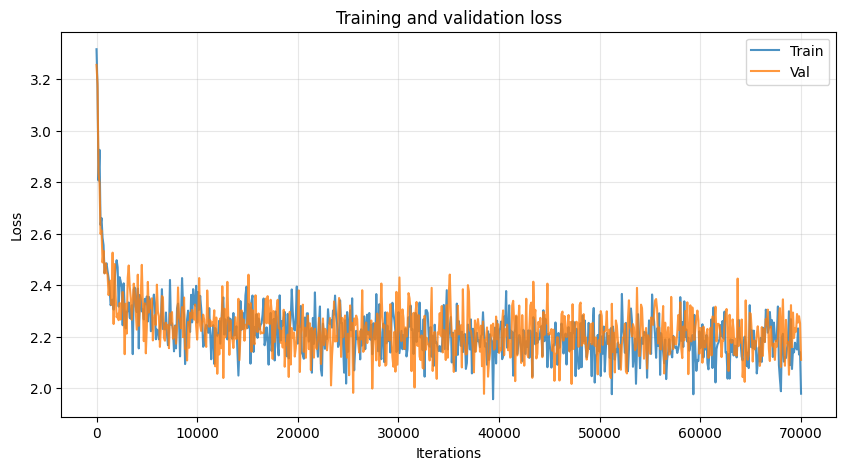

In [10]:
# Plot training and validation loss (each point = track_interval iters)
if len(lossi) > 0:
    iterations = torch.arange(len(lossi)) * track_interval
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, lossi, label="Train", alpha=0.8)
    plt.plot(iterations, val_lossi, label="Val", alpha=0.8)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No loss history (training not run or no track_interval points).")

In [11]:
# Evaluation: train and val loss
@torch.no_grad()
def split_loss(split: str) -> float:
    model.eval()
    splits = {
        "train": (Xtr, Ytr, Ctr),
        "val": (Xdev, Ydev, Cdev),
        "test": (Xte, Yte, Cte),
    }
    X, Y, C = splits[split]
    n = min(2048, X.shape[0])
    Xb = X[:n].to(device)
    Yb = Y[:n].to(device)
    Cb = C[:n].to(device)
    logits, _ = model(Xb, Cb, targets=Yb)
    loss = F.cross_entropy(logits, Yb)
    return loss.item()

# print(f"Train loss: {split_loss('train'):.4f}")
print(f"Val loss:   {split_loss('val'):.4f}")

Val loss:   2.2152


In [12]:
# Generate names for a given category
gen = torch.Generator(device=device).manual_seed(2147483647 + 1)

cat_name = "dwarves"
cat_idx = next((k for k, v in cat_vocab.itos.items() if v.lower() == cat_name), 0)

for _ in range(15):
    name = model.generate(cat_idx, char_vocab.itos, generator=gen)
    print(f"[{cat_name}] {name}")

[dwarves] shyung goulgjim
[dwarves] arane ghuljazzet
[dwarves] luciora ghuluugwoba
[dwarves] kamela ghulvilgo
[dwarves] achiya ghulzxuruca
[dwarves] labemen ghulducugzus
[dwarves] gosion ghulnogdoe
[dwarves] lucista galic
[dwarves] emette gademhins
[dwarves] yakul ghulbhadrok
[dwarves] lio ghuldazriz
[dwarves] kristopheradow azuy
[dwarves] haldy ghuluzzzkoz
[dwarves] lyn ghulchuoz
[dwarves] gershana ghulbheliss


In [13]:
# Random category sampling
import random

gen = torch.Generator(device=device).manual_seed(2147483647 + 2)
cat_indices = list(cat_vocab.itos.keys())

for _ in range(10):
    c = random.choice(cat_indices)
    cat_label = cat_vocab.itos[c]
    name = model.generate(c, char_vocab.itos, generator=gen)
    print(f"[{cat_label}] {name}")

[italiano] tquijia ghulgzach
[baltic] heamiphven ghuldog
[asianish] ariba ghjoznegruk
[asianish] orusla ghulriniggba
[mayan] satian ghulduidephb
[nordic] panhetter gciegallan
[middleeastern] iljran e
[nordic] ovelda ghuluzdag
[mayan] metolno tvilazizo
[nordic] sulaj ghly
